In [1]:
from nltk import sent_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation
from string import punctuation
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Sentiment Scoring Using SentiWordNet

In [2]:
def penn_to_wn(tag):
    """
        Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [3]:
def get_sentiment_score(text):
    
    """
        This method returns the sentiment score of a given text using SentiWordNet sentiment scores.
        input: text
        output: numeric (double) score, >0 means positive sentiment and <0 means negative sentiment.
    """    
    total_score = 0
    #print(text)
    raw_sentences = sent_tokenize(text)
    #print(raw_sentences)
    
    for sentence in raw_sentences:

        sent_score = 0     
        sentence = str(sentence)
        #print(sentence)
        sentence = sentence.replace("<br />"," ").translate(str.maketrans('','',punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        tags = pos_tag(tokens)
        for word, tag in tags:
            wn_tag = penn_to_wn(tag)
            if not wn_tag:
                continue
            lemma = WordNetLemmatizer().lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sent_score += swn_synset.pos_score() - swn_synset.neg_score()

        total_score = total_score + (sent_score / len(tokens))

    
    return (total_score / len(raw_sentences)) * 100

In [4]:
reviews = pd.read_csv("../data/small_corpus.csv")

In [5]:
reviews.shape

(4500, 12)

In [6]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"11 30, 2015",A3AC92K59QLYR8,B00503E8S2,ben,Game freezes over and over its unplayable,it just doesn't work,1448841600,NaN,{'Format:': ' Video Game'},NaN
1,1.0,False,"05 19, 2012",A334LHR8DWARY8,B00178630A,Xenocide,"I have no problem with needing to be online to play and have had no problems with stability since the first 2 days. This review ignores those issues.\n\nThe game itself is fun and addictive, but so is Din's Curse (which was programmed by one guy) and is more re-playble than Diablo 3. Hopefully Torchlight 2 will take the mantle of this genere from Blizzard. One reason all these games are fun is because they are all similar in atmosphere, gameplay and loot system. As a stand alone title, D3 would be 4 stars, maybe- but as a successor to Diablo 2, with all the man-power and resources Blizzard had including the beautiful skill tree system from D2... If I could go lower than 1, I would.\n\nWhy was Diablo 2 addictive? One big reason was farming gear- loading magic find amd finding a group for Hell runs, kind of like a drug. But why? For the millions of regular players it was in order to gear up their next specialized build. Everything was centered around unique builds that become somewhat cookie cutter if good. Players perfectly balancing point distributions in attributes and skills to make that personalized zealot or blizzard sorc. The quest for constant gear for new builds was what drove the desire to aquire it. Every major nerf patch was like a ladder reset (which D3 lacks). Even if they add another 5 classes, the problem of no variation or ability to make a custom character means no constant demand for anything but a few top level items.\n\nThis seems intentional to keep server use lighter between expansions as there really is little reason to play unless your into farming for only a handful of desired endgame items. Everything else can be gotten off the AH for little gold. Unless they introduce raids that give special gear or something that would make that game into an MMO, none of the desire to keep playing is there unless it's more of a social hang-out.\n\nSo, where did all the money and time go? The skills are fun, as are the runes- but also very simplistic. The cut-screens are nicely done but, in this genere, most people watch them once or twice at most, they are basically useless. I'd hate to think all the resources went there when the cut-screens are movie quality where you see real looking people crying and giving decent lines, but then we shift back to real game-play and the next line from the smith who just killed his wife after she vomited and changed into an undead creature is a comically gruff and bemused... ""If you see my idiot apprentice out there, tell him to get back...""\n\nThe same companion dialogue reapeated over and over and often when fighting so it's annoying. It's all just randomized for the most part. So, your talking to your companions in a casual way about something trivial while getting killed by a boss. Poor execution of useless content. It happens often as well.\n\nIt is just sad to see no ability to customize a build, choose your dialogue or do much outside of what this game present to you. You essentially walking through how the developers envisioned you to progress- from what you say to what skills you want to master.\n\nIt's really sad to see how they dumbed this game down to the point where there is no ability to customize any aspect of your gameplay.",The only real way to show Blizzard our feelings is through Ultimate ratings,1337385600,23,{'Format:': ' Computer Game'},NaN
2,1.0,True,"10 19, 2014",A28982ODE7ZGVP,B001AWIP7M,Eric Frykberg,NOT GOOD,One Star,1413676800,NaN,{'Format:': ' Video Game'},NaN
3,1.0,True,"09 6, 2015",A19E85RLQCAMI1,B00NASF4MS,Joe,Really not worth the money to buy this game on PS4 unless it becomes $10.... don't make the mistake I made.,Real

In [7]:
reviews.dropna(subset=['reviewText'], inplace=True)

In [8]:
reviews.shape

(4499, 12)

In [9]:
reviews['swn_score'] = reviews['reviewText'].apply(lambda text : get_sentiment_score(text))

In [10]:
reviews[['reviewText','swn_score']].sample(2)

,reviewText,swn_score
2971,"Game still works great with my older instruments, my guitar and drumset needed some calibration tweaks but now work fine. It still supports the cymbals add ons. I like the new set-list, not as many classics as previous games but I've discovered some great songs (new and old) that play great and that's what matters.\n\nFreestyle guitar solos are fun, it takes some practice to get them to sound decent, but purists will appreciate the ability to turn this feature off. Drum freestyles are little more disappointing, they seem too random and throw off my timing more often than not, so I turned them off.\n\nStill unable to export RB1 and RB2 songs, though they promised that would be ready at launch, not clear to me when these will be ready. I'm also having issues with some of my paid DLC tracks not showing up. Again, it's not clear to me if or when these issues will eventually be addressed. Still 95% of my purchased songs made the transition, so I got enough to keep me busy!\n\nI also hope they change their minds about keyboard support someday, even if it a paid add-on I would get it, I miss playing my keyboard.",1.841518
50,"This is not a ""collection"". False advertising, hence a low rating. It does *not* include any expansions or additional content. It's simply a re-packaged Castlevania: Lords of Shadow.\n\nIt also includes some one-time-use service codes that might work for a few years and someday won't work anymore.\n\nBe careful not to fall for the lies on the front of the box if you want to archive anything more than vanilla Castlevania: Lords of Shadow (a great game, but marred in this case by deceptive marketing).",-1.546392


In [11]:
reviews[['reviewText','swn_score']].sample(2)

,reviewText,swn_score
3540,"A little hard to figure out at first, but once you get the hang of it you'll be playing it for long periods at a time. Compared to the other harvest moon games this one was alot easier to understand for me. The plot makes sense to the game and it is guided along as you go.",-0.208333
1381,sadly i didn't see the spot that says you have to have XBOX gold to play this. Grandson was very dissapointed.,0.000000


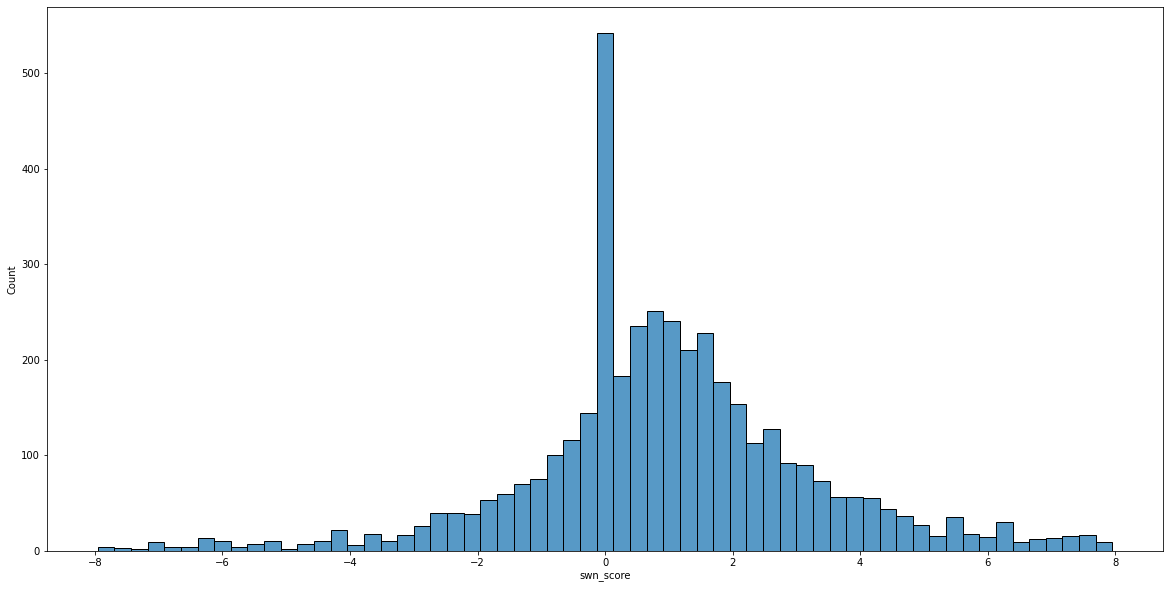

In [43]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='swn_score', data=reviews.query("swn_score < 8 and swn_score > -8"), ax=ax)
plt.show()

In [54]:
reviews['swn_sentiment'] = reviews['swn_score'].apply(lambda x: "positive" if x>1 else ("negative" if x<0.5 else "neutral"))

In [55]:
reviews['swn_sentiment'].value_counts(dropna=False)

positive    2199
negative    1823
neutral      477
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

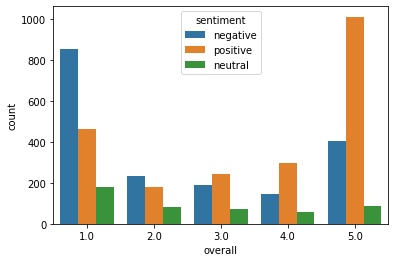

In [56]:
sns.countplot(x='overall', hue='swn_sentiment' ,data = reviews)

<AxesSubplot:xlabel='sentiment', ylabel='overall'>

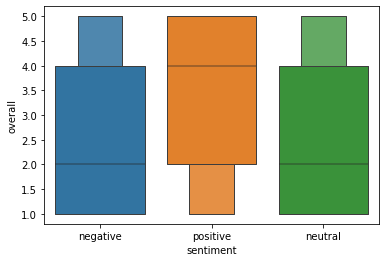

In [57]:
sns.boxenplot(x='swn_sentiment', y='overall', data = reviews)

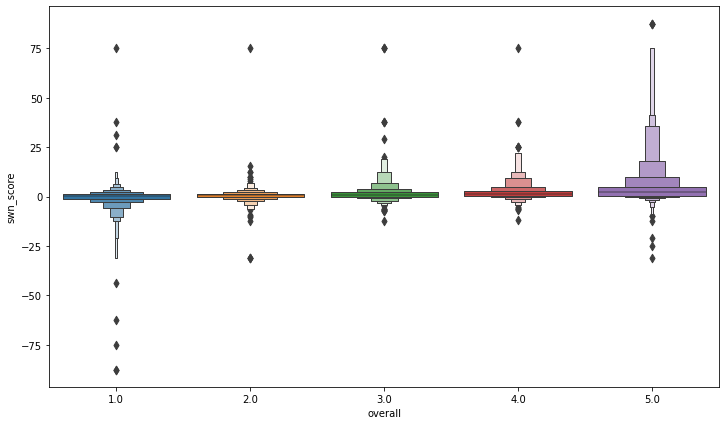

In [148]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,7))
sns.boxenplot(x='overall', y='swn_score', data = reviews, ax=ax)
plt.show()

### Sentiment Scoring Model Using NLTK Opinion Lexicon

In [63]:
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize

In [64]:
nltk.download("opinion_lexicon")

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/koosha.tahmasebipour/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

In [70]:
pos_words = list(opinion_lexicon.positive())
neg_words = list(opinion_lexicon.negative())

In [71]:
def get_sentiment_score_oplex(text):
    
    """
        This method returns the sentiment score of a given text using nltk opinion lexicon.
        input: text
        output: numeric (double) score, >0 means positive sentiment and <0 means negative sentiment.
    """    
    total_score = 0

    raw_sentences = sent_tokenize(text)
    
    for sentence in raw_sentences:

        sent_score = 0     
        sentence = str(sentence)
        sentence = sentence.replace("<br />"," ").translate(str.maketrans('','',punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        for token in tokens:
            sent_score = sent_score + 1 if token in pos_words else (sent_score - 1 if token in neg_words else sent_score)
        total_score = total_score + (sent_score / len(tokens))

    
    return total_score

In [73]:
reviews['oplex_sentiment_score'] = reviews['reviewText'].apply(lambda x: get_sentiment_score_oplex(x))

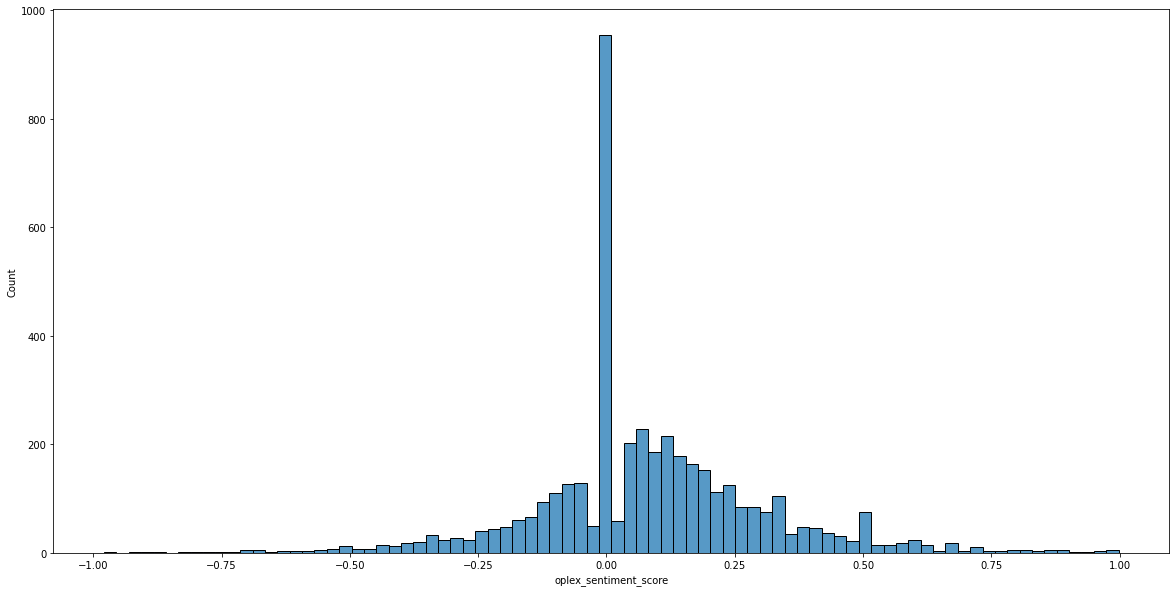

In [76]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='oplex_sentiment_score',\
             data=reviews.query("oplex_sentiment_score < 1 and oplex_sentiment_score>-1"), ax=ax)
plt.show()

In [140]:
reviews['oplex_sentiment'] = \
    reviews['oplex_sentiment_score'].apply(lambda x: "positive" if x>0.1 else ("negative" if x<0 else "neutral"))

In [141]:
reviews['oplex_sentiment'].value_counts(dropna=False)

positive    1875
neutral     1582
negative    1042
Name: oplex_sentiment, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

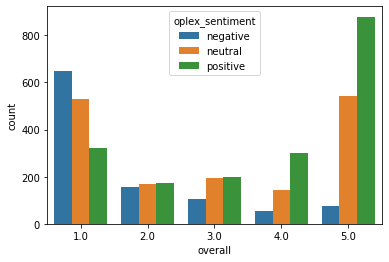

In [142]:
sns.countplot(x='overall', hue='oplex_sentiment' ,data = reviews)

<AxesSubplot:xlabel='oplex_sentiment', ylabel='overall'>

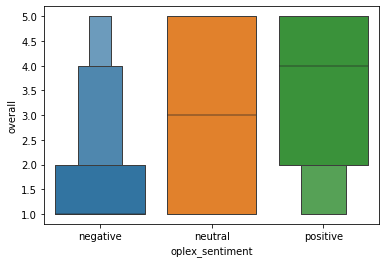

In [143]:
sns.boxenplot(x='oplex_sentiment', y='overall', data = reviews)

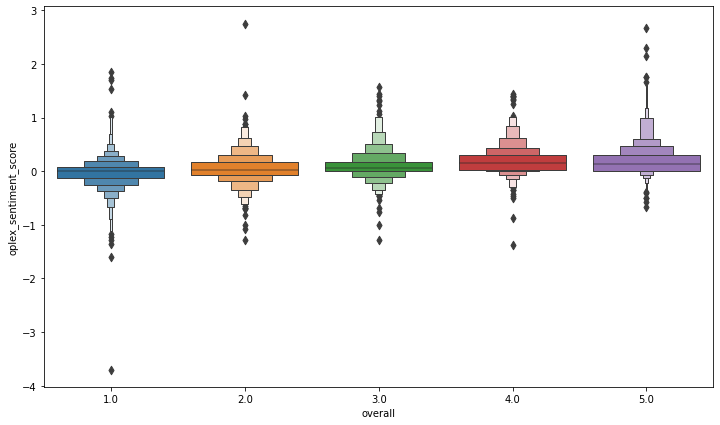

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,7))
sns.boxenplot(x='overall', y='oplex_sentiment_score', data = reviews, ax=ax)
plt.show()